In [1]:
import os, itertools
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'figure.figsize': (40, 8), 'font.family': 'serif', 'text.usetex': True, 'pgf.rcfonts': False})

%load_ext autoreload
%autoreload 2

import jax
jax.config.update('jax_platform_name', 'cpu')
    
from jax_smolyak import indices, nodes
from jax_smolyak.smolyak import SmolyakBarycentricInterpolator

We consider the high-dimensional test target function $f : [-1,1]^d \to \mathbb{R}$
given by
$$ f(\boldsymbol{x}) = \frac{1}{1 + \Theta \sum_{j=1}^d (j+1)^{-r} x_j} $$
for some $\Theta \in (0,1)$ and $r\ge1$, which can be implemented in vectorized form as

In [2]:
def target_f(x, theta, r) :
    return 1/(1+ theta * np.sum(x * (np.arange(x.shape[-1]) + 2)**(-r), axis=-1))

We test the convergence of the Smolyak operator constructed from multi-index sets of the form $$\Lambda = \{\boldsymbol\nu\in \mathbb{N}_0^d \ : \ \sum_{j=1}^d \nu_j \log \left(\frac{(j+1)^{r}}{\theta}\right) < t\}$$ as the cardinality of the multi-index set (controlled via $\ell$) goes to $\infty$ via a Monte-Carlo estimate of the relative $L^2$ error:

In [3]:
def mc_mse_estimate(f, ip, node_gen, n=500) :
    x = node_gen.get_random(n)
    fx = f(x)
    return np.sqrt(np.mean((fx - np.squeeze(ip(x)))**2) / np.mean(fx**2))

We obtain the following convergence for $d = 100$ and parameters $r=2$ and $\theta=0.1$:

In [4]:
d, r, theta = 100, 2., .1

f = lambda x : target_f(x, theta, r)
node_gen = nodes.Leja(dim=d)
k  = [np.log((ki+2)**(r)/theta) for ki in range(d)]
max_t = indices.find_suitable_t(k, 1000, node_gen.is_nested)
ips = [SmolyakBarycentricInterpolator(node_gen=node_gen, k=k, t=t, d_out=1, f=f) for t in np.linspace(1,max_t,10)]
err = np.zeros((len(ips),))
for i, ip in enumerate(ips) :
    err[i] = mc_mse_estimate(f, ip, node_gen)

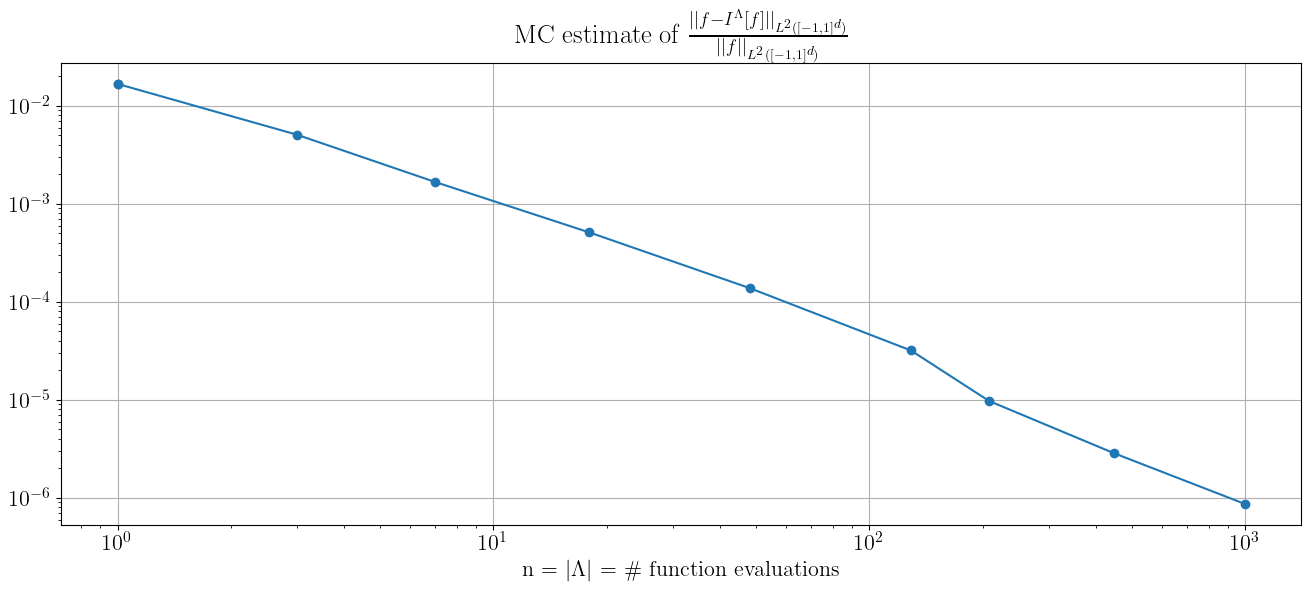

In [5]:
ax = plt.figure(figsize=(16, 6)).add_subplot(111)
ax.loglog([s.n_f_evals for s in ips], err, marker='o')
ax.set_xlabel(r'n = $|\Lambda|$ = \# function evaluations'); ax.set_title(r'MC estimate of $\frac{||f - I^\Lambda[f]||_{L^2([-1,1]^d)}}{||f||_{L^2([-1,1]^d)}}$'); ax.grid();